In [13]:
import re, pandas as pd, matplotlib
%matplotlib inline

In [14]:
suffix='9'
cpath = 'client'+suffix+'.log'
spath = 'server'+suffix+'.log'

In [15]:
def extract(path, pat):
    return [
        map(float, m.groups())
        for line in open(path)
        for m in [re.match(pat, line)]
        if m
    ]

In [66]:
cjank = pd.DataFrame(extract(cpath, r'(.+) bcast: time (.+) thisDelta (.+) delta (.+) length (.+)'),
                     columns=['logtime','time','this_delta','delta','length'])

In [99]:
cjank['gap'] = [0] + cjank.time.diff()
cjank['stime'] = cjank['time'] + cjank['this_delta']

In [68]:
base = max(cjank['this_delta'].min(), cjank['delta'].max())
cjank['rebase_delta'] = cjank['delta'] - base
cjank['rebase_this_delta'] = cjank['this_delta'] - base

In [100]:
cjank.describe()

,logtime,time,this_delta,delta,length,gap,rebase_delta,rebase_this_delta,stime
count,1120.000000,1120.000000,1.120000e+03,1.120000e+03,1120.000000,1119.000000,1120.000000,1120.000000,1.120000e+03
mean,58369.432933,58369.419701,1.509161e+12,1.509161e+12,501.882143,61.939544,-23.641573,-21.789524,1.509161e+12
std,20073.212412,20073.213146,5.632095e+01,3.082652e+01,62.779288,44.118174,30.826523,56.320954,2.008457e+04
min,23878.755000,23878.550000,1.509161e+12,1.509161e+12,434.000000,0.085000,-239.807373,-390.122314,1.509161e+12
25%,40959.567500,40959.557500,1.509161e+12,1.509161e+12,489.000000,56.615000,-31.899719,-7.801086,1.509161e+12
50%,58316.750000,58316.725000,1.509161e+12,1.509161e+12,490.000000,61.980000,-11.810303,-1.284790,1.509161e+12
75%,75731.993750,75731.983750,1.509161e+12,1.509161e+12,492.000000,64.545000,-3.443298,0.533936,1.509161e+12
max,93188.910000,93188.900000,1.509161e+12,1.509161e+12,1455.000000,449.780000,0.000000,3.762695,1.509161e+12


## Timestamps of received packets

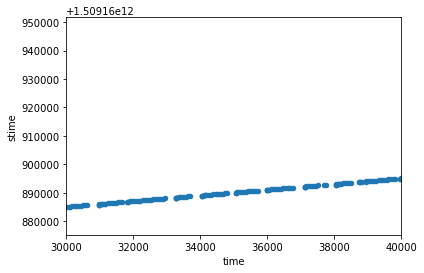

In [111]:
cjank[['time','stime']].plot.scatter('time','stime', xlim=(30000,40000))

## Jitter in delta

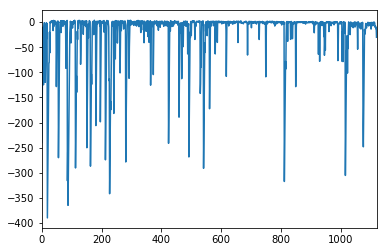

In [70]:
cjank['rebase_this_delta'].plot()

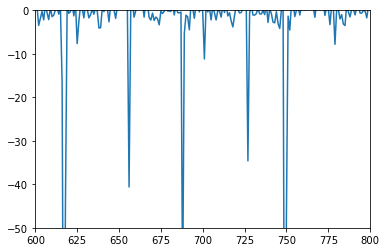

In [71]:
cjank['rebase_this_delta'].plot(xlim=(600,800), ylim=(-50,0))

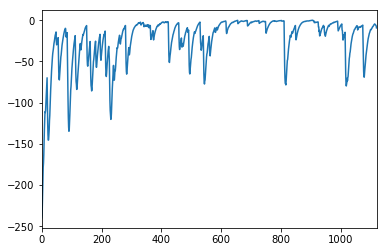

In [72]:
cjank['rebase_delta'].plot()

## Time between bcasts

Lines up with above jitter as expected.

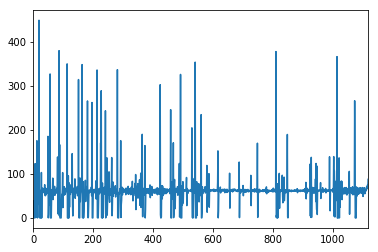

In [73]:
cjank['gap'].plot()

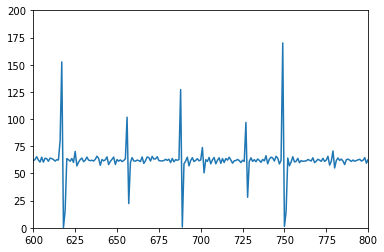

In [74]:
cjank['gap'].plot(xlim=(600,800), ylim=(0,200))

## Data lengths

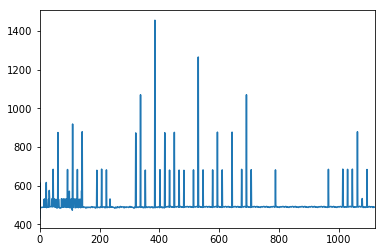

In [75]:
cjank['length'].plot()

# Timeline

In [45]:
ctimeline = pd.DataFrame(extract(cpath, r'(.+) timeline: time (.+) delta (.+) targetTime (.+) t0 (.+) t1 (.+) index (.+) total buffered (.+)'),
                         columns=['logtime','time','delta','target_time','t0','t1','index','total_buffered'])

In [49]:
ctimeline['gap'] = [0] + ctimeline['time'].diff()

In [50]:
ctimeline.describe()

,logtime,time,delta,target_time,t0,t1,index,total_buffered,gap
count,2054.000000,2054.000000,2.054000e+03,2.054000e+03,2.054000e+03,2.054000e+03,2054.000000,2054.000000,2053.000000
mean,48837.684516,48836.573177,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,26.812561,31.980526,33.238139
std,20837.498573,20837.531290,2.174119e+01,2.084267e+04,2.083744e+04,2.084352e+04,9.531010,0.344196,723.571220
min,24981.740000,24971.515000,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.000000,20.000000,7.145000
25%,34238.067500,34237.026250,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,30.000000,32.000000,16.475000
50%,42893.435000,42892.550000,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,30.000000,32.000000,16.680000
75%,51516.126250,51514.883750,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,30.000000,32.000000,16.880000
max,93210.650000,93209.415000,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,31.000000,32.000000,32800.315000


## Received

In [ ]:
ctimeline['t1']

## Playback

This is how much behind the latest server timestamp the client playback is hovering at.

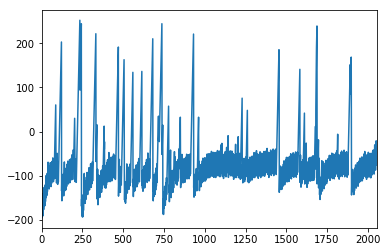

In [83]:
(ctimeline['target_time'] - ctimeline['t1']).plot()

Client playback is frequently waiting for packets.

In [63]:
(ctimeline['t1'] < ctimeline['target_time']).sum()

215

Each spike in the above plot is actually a linearly growing lag.  Frames tick by where the target is steadily marching forward but there's nothing to play.  And things appear suddenly, without warning - no wiggle room to gradually slow down the simulation since we always try to run "close to the end" to minimize latency.

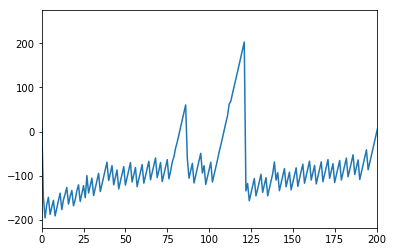

In [87]:
(ctimeline['target_time'] - ctimeline['t1']).plot(xlim=(0,200))

These correspond to the times the jank is bad.

In [76]:
ctimeline.loc[ctimeline['t1'] < ctimeline['target_time']]

,logtime,time,delta,target_time,t0,t1,index,total_buffered,gap
0,24981.740,24971.515,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,20.0,NaN
83,26767.050,26765.815,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,17.545
84,26782.345,26781.555,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,15.740
85,26799.500,26798.440,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,16.885
86,26816.765,26815.255,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,16.815
109,27199.520,27198.365,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,16.110
110,27216.900,27215.585,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,17.220
111,27232.815,27231.720,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,16.135
112,27258.810,27257.840,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,26.120
113,27265.745,27264.985,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,7.145


In [76]:
ctimeline.loc[ctimeline['t1'] < ctimeline['target_time']]

,logtime,time,delta,target_time,t0,t1,index,total_buffered,gap
0,24981.740,24971.515,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,20.0,NaN
83,26767.050,26765.815,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,17.545
84,26782.345,26781.555,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,15.740
85,26799.500,26798.440,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,16.885
86,26816.765,26815.255,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,16.815
109,27199.520,27198.365,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,16.110
110,27216.900,27215.585,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,17.220
111,27232.815,27231.720,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,16.135
112,27258.810,27257.840,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,26.120
113,27265.745,27264.985,1.509161e+12,1.509161e+12,1.509161e+12,1.509161e+12,-1.0,32.0,7.145


In [80]:
cjank.loc[cjank['rebase_this_delta']<-10]

,logtime,time,this_delta,delta,length,gap,rebase_delta,rebase_this_delta
0,23878.755,23878.550,1.509161e+12,1.509161e+12,434.0,NaN,-239.807373,-239.807373
1,23917.330,23917.300,1.509161e+12,1.509161e+12,615.0,38.750,-236.582520,-207.557373
2,23917.490,23917.480,1.509161e+12,1.509161e+12,487.0,0.180,-226.697754,-137.737305
3,23917.600,23917.595,1.509161e+12,1.509161e+12,487.0,0.115,-211.413086,-73.852295
5,24033.040,24033.015,1.509161e+12,1.509161e+12,488.0,115.315,-178.467773,-63.272217
6,24156.605,24156.585,1.509161e+12,1.509161e+12,488.0,123.570,-173.105225,-124.842285
7,24163.270,24163.260,1.509161e+12,1.509161e+12,488.0,6.675,-162.746582,-69.517334
10,24312.845,24312.825,1.509161e+12,1.509161e+12,489.0,94.040,-122.722656,-34.082275
12,24522.680,24522.665,1.509161e+12,1.509161e+12,490.0,175.675,-111.959473,-119.922363
13,24551.755,24551.740,1.509161e+12,1.509161e+12,490.0,29.075,-109.363281,-85.997314


(Amazingly?) We are never skipping over frames / shifting them off the end without processing them.

(What would that take?  It would require some sort of burst (ignores deltas) or an accelerated rate of packet arrival (a game of deltas).  E.g., a sudden burst of 50, or the delta gets pushed up from some transient lag and then things arrive at a faster pace, faster than the adaptive delta can react.)

In [64]:
(ctimeline['t0'] > ctimeline['target_time']).sum()

0

## Framerate

I don't remember what was behind this time jump, but let's ignore it.

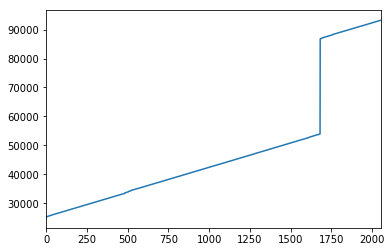

In [52]:
ctimeline['time'].plot()

60 fps should correspond to about 16.6 ms per frame, which we see here, but there are some seriously large spikes.  I'm not sure what's causing these in the raw framerate - client side performance jitter is definitely something to dig into!

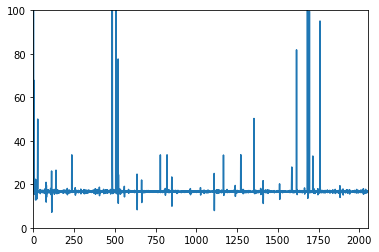

In [113]:
ctimeline['gap'].plot(ylim=(0,100))

# Old shit

In [38]:
sjank = pd.DataFrame(extract(spath, r'server-jank: start (.+) end (.+) elapsed (.+)'),
                     columns=['start','end','elapsed'])

In [39]:
sjank

,start,end,elapsed
0,1.508522e+12,1.508522e+12,61.0
1,1.508522e+12,1.508522e+12,97.0
2,1.508522e+12,1.508522e+12,27.0
3,1.508522e+12,1.508522e+12,16.0
4,1.508522e+12,1.508522e+12,12.0
5,1.508522e+12,1.508522e+12,44.0
6,1.508522e+12,1.508522e+12,20.0
7,1.508522e+12,1.508522e+12,22.0
8,1.508522e+12,1.508522e+12,18.0
9,1.508522e+12,1.508522e+12,11.0


In [43]:
cbcast = pd.DataFrame(extract(cpath, r'bcast: time (.+) thisDelta (.+) delta (.+)'),
                     columns=['time','this_delta','delta'])

In [44]:
cbcast

,time,this_delta,delta
0,36311.505,1.508523e+12,1.508523e+12
1,36380.080,1.508523e+12,1.508523e+12
2,36456.190,1.508523e+12,1.508523e+12
3,36524.265,1.508523e+12,1.508523e+12
4,36590.540,1.508523e+12,1.508523e+12
5,36660.720,1.508523e+12,1.508523e+12
6,36730.965,1.508523e+12,1.508523e+12
7,36806.240,1.508523e+12,1.508523e+12
8,36872.850,1.508523e+12,1.508523e+12
9,36941.185,1.508523e+12,1.508523e+12


In [68]:
cbcast['time gap'] = [0] + cbcast['time'].diff()

In [69]:
cbcast.describe()

,time,this_delta,delta,time gap
count,404.000000,4.040000e+02,4.040000e+02,403.000000
mean,50552.657611,1.508523e+12,1.508523e+12,70.677283
std,8256.084686,2.673426e+01,9.577076e+00,24.387382
min,36311.505000,1.508523e+12,1.508523e+12,3.365000
25%,43446.375000,1.508523e+12,1.508523e+12,67.357500
50%,50542.340000,1.508523e+12,1.508523e+12,69.375000
75%,57646.060000,1.508523e+12,1.508523e+12,72.367500
max,64794.450000,1.508523e+12,1.508523e+12,268.000000


In [49]:
sbcast = pd.DataFrame(extract(spath, r'bcast: tick (.+) player (.+) snap time (.+) send done time (.+)'),
                     columns=['tick','player','snap_time','send_done_time'])

In [50]:
sbcast

,tick,player,snap_time,send_done_time
0,109.0,651.0,1.508523e+12,1.508523e+12
1,110.0,651.0,1.508523e+12,1.508523e+12
2,111.0,651.0,1.508523e+12,1.508523e+12
3,112.0,651.0,1.508523e+12,1.508523e+12
4,113.0,651.0,1.508523e+12,1.508523e+12
5,114.0,651.0,1.508523e+12,1.508523e+12
6,115.0,651.0,1.508523e+12,1.508523e+12
7,116.0,651.0,1.508523e+12,1.508523e+12
8,117.0,651.0,1.508523e+12,1.508523e+12
9,118.0,651.0,1.508523e+12,1.508523e+12


In [52]:
sbcast['snap gap'] = [0] + sbcast.snap_time.diff()

In [53]:
sbcast['tick gap'] = [0] + sbcast.tick.diff()

In [60]:
sbcast['send_time'] = sbcast['send_done_time'] - sbcast['snap_time']

In [71]:
sbcast.describe()

,tick,player,snap_time,send_done_time,snap gap,tick gap,send_time
count,1502.000000,1502.0,1.502000e+03,1.502000e+03,1501.000000,1501.0,1502.000000
mean,859.500000,651.0,1.508523e+12,1.508523e+12,71.317122,1.0,18.197736
std,433.734366,0.0,3.081982e+04,3.081958e+04,3.350129,0.0,3.072115
min,109.000000,651.0,1.508523e+12,1.508523e+12,64.000000,1.0,14.000000
25%,484.250000,651.0,1.508523e+12,1.508523e+12,69.000000,1.0,17.000000
50%,859.500000,651.0,1.508523e+12,1.508523e+12,71.000000,1.0,18.000000
75%,1234.750000,651.0,1.508523e+12,1.508523e+12,73.000000,1.0,19.000000
max,1610.000000,651.0,1.508523e+12,1.508523e+12,105.000000,1.0,52.000000
